In [8]:
import PyQt6.QtCore
import os
os.environ["QT_API"] = "pyqt6"
import matplotlib.pyplot as plt

# Use qt backend for matplotlab to use interactive mne plots
%matplotlib qt

In [9]:
import mne 
import analysis.processing
import pandas as pd
import csv 
import os
from config import Config
configObj = Config()
from mne_connectivity import spectral_connectivity_time
import numpy as np
configss = configObj.getConfigSnapshot()

mne.set_log_level(verbose='WARNING', return_old_level=False, add_frames=None)

In [9]:
analysis.processing.segmentData(list(range(15, 32)), preprocess = True)

Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=4


c:\Users\erangad\Desktop\Research\reading_task\src\analysis\processing.py:57: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_filtered.set_montage(montage)
c:\Users\erangad\Desktop\Research\reading_task\src\analysis\processing.py:57: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_filtered.set_montage(montage)
c:\Users\erangad\Desktop\Research\reading_task\src\analysis\processing.py:57: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_filtered.set_montage(montage)
c:\Users\erangad\Desktop\Research\reading_task\src\analysis\processing.py:57: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_filtered.set_montage(montage)
c:\Users\erangad\Desktop\Research\reading_task\src\analysis\processing.py:57: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown

In [37]:
analysis.processing.segmentData([8], preprocess = True)

c:\Users\erangad\Desktop\Research\reading_task\src\analysis\processing.py:57: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_filtered.set_montage(montage)


In [6]:


listsss =  [el for el in list(range(1,32)) if el != 14]

In [8]:
for pnum in (listsss):
    for b_cnt in range (0, 4):
        block_nums = [ x+ (str(b_cnt)) for x in ['D', 'ND']  ]
        for block_num in block_nums:
            raw = analysis.processing.loadSegmentedData(pnum, block_num)
            epochs = analysis.processing.epochContinuousData(raw)
            
            participant_number = 'P' + str(pnum)
            partipant_data_path = participant_number + '/' + block_num +'-epo.fif'
            path = os.path.join(configss['root'], configss['data_dir'] , partipant_data_path ) 

            epochs.save(path, overwrite= True)
            
        

NameError: name 'analysis' is not defined

In [37]:
import pickle
# Initialize lists to store connectivity matrices for each condition
connectivity_matrices_D = []
connectivity_matrices_ND = []

n_channels = 62

for pnum in (1,2,4 ):
    for b_cnt in range (0, 2):
        block_nums = [ x+ (str(b_cnt)) for x in ['D', 'ND']  ]
        for block_num in block_nums:
            # raw = analysis.processing.loadSegmentedData(pnum, block_num)
    
            # epochs = mne.make_fixed_length_epochs(raw, duration= 3, preload=True)

            participant_number = 'P' + str(pnum)
            partipant_data_path =  'Pilot'+ '/'+ participant_number + '/' + block_num +'-epo.fif'
            path = os.path.join(configss['root'], configss['data_dir'] , partipant_data_path ) 

            epochs = mne.read_epochs(path, preload= True)
            # epochs = analysis.processing.removeArtifacts(raw, epochs)
            #surface laplasian
            epochs = mne.preprocessing.compute_current_source_density(epochs)

            # Freq bands of interest
            Freq_Bands = {"theta": [4.0, 8.0], "alpha": [8.0, 13.0], "beta": [13.0, 30.0]}
            n_freq_bands = len(Freq_Bands)
            min_freq = np.min(list(Freq_Bands.values()))
            max_freq = np.max(list(Freq_Bands.values()))

            # The dictionary with frequencies are converted to tuples for the function
            fmin = tuple([list(Freq_Bands.values())[f][0] for f in range(len(Freq_Bands))])
            fmax = tuple([list(Freq_Bands.values())[f][1] for f in range(len(Freq_Bands))])

            # Provide the freq points
            freqs = np.linspace(min_freq, max_freq, int((max_freq - min_freq) * 4 + 1))

            # We will try two different connectivity measurements as an example
            connectivity_methods = ['wpli']
            n_con_methods = len(connectivity_methods)
            n_epochs = len(epochs.events)

            # Pre-allocatate memory for the connectivity matrices
            con_time_array = np.zeros(
                (n_epochs, n_channels, n_channels, n_freq_bands)
            )

            n_cycles = np.linspace(2, 7, int((max_freq - min_freq) * 4 + 1))


            # Compute connectivity over time
            con_time = spectral_connectivity_time(
                epochs,
                freqs= freqs,
                method= connectivity_methods,
                mode="cwt_morlet",
                faverage=True,
                fmin=fmin,
                fmax=fmax,
                n_cycles = n_cycles
            )

            # Get data as connectivity matrices
            # for c in range(n_con_methods):
            #     con_time_array[c] = con_time[c].get_data(output="dense")

            con_time_array =   con_time.get_data(output="dense")
            con_time_array =    np.mean(con_time_array, axis = 0)

            if(block_num.startswith('D')):
                if b_cnt == 0:
                   connectivity_matrices_D = con_time_array
                else: 
                    connectivity_matrices_D = np.stack((connectivity_matrices_D, con_time_array), axis=0)
                    formatted_string = "connectivity_matrices_D_{}.pkl".format(pnum)
                    with open(formatted_string, 'wb') as file:
                        pickle.dump(connectivity_matrices_D, file)
                      


            if(block_num.startswith('ND')):
                if b_cnt == 0:
                   connectivity_matrices_ND = con_time_array
                else:
                    connectivity_matrices_ND = np.stack((connectivity_matrices_ND, con_time_array), axis=0)
                    formatted_string = "connectivity_matrices_ND_{}.pkl".format(pnum)
                    with open(formatted_string, 'wb') as file:
                        pickle.dump(connectivity_matrices_ND, file)            
            


In [41]:
import pickle
# Initialize lists to store connectivity matrices for each condition
connectivity_matrices_D = None
connectivity_matrices_ND = None

for pnum in (1,2,4 ):

    formatted_string = "connectivity_matrices_D_{}.pkl".format(pnum)
    with open(formatted_string, 'rb') as file:
        if connectivity_matrices_D is None:
            connectivity_matrices_D =  np.array(pickle.load(file))
        else:
            connectivity_matrices_D = np.concatenate((connectivity_matrices_D, np.array(pickle.load(file))), axis =0) 

    formatted_string = "connectivity_matrices_ND_{}.pkl".format(pnum)
    with open(formatted_string, 'rb') as file:
        if connectivity_matrices_ND is None:
            connectivity_matrices_ND =  np.array(pickle.load(file))
        else:
            connectivity_matrices_ND = np.concatenate((connectivity_matrices_ND, np.array(pickle.load(file))), axis =0)       

In [38]:
formatted_string = "connectivity_matrices_ND_{}.pkl".format(1)
with open(formatted_string, 'rb') as file:
    connectivity_matrices_ND =  np.array(pickle.load(file))

In [39]:
connectivity_matrices_ND.shape

(2, 62, 62, 3)

In [6]:
# import pickle

# with open('connectivity_matrices_ND_1.pkl', 'wb') as file:
#     pickle.dump(connectivity_matrices_ND, file)


# with open('connectivity_matrices_D_1.pkl', 'wb') as file:
#     pickle.dump(connectivity_matrices_D, file)

In [13]:
with open('connectivity_matrices_ND.pkl', 'rb') as file:
    print(np.array(pickle.load(file)).shape)

(2, 6, 62, 62, 3)


In [3]:
import pickle

with open('connectivity_matrices_ND_1.pkl', 'rb') as file:
   connectivity_matrices_ND =  np.array(pickle.load(file)) 

with open('connectivity_matrices_D_1.pkl', 'rb') as file:
    connectivity_matrices_D = np.array(pickle.load(file))

In [34]:
connectivity_matrices = np.stack((connectivity_matrices_D, connectivity_matrices_ND)) 

In [ ]:
connectivity_matrices_ND = np.mean(connectivity_matrices_ND, axis = 0)

In [35]:
connectivity_matrices_ND.shape

(124, 62, 3)

In [35]:
connectivity_matrices_ND.shape

(62, 62, 3)

In [14]:
with open('connectivity_matrices_ND.pkl', 'rb') as file:
    connectivity_matrices_ND = np.concatenate((connectivity_matrices_ND, np.array(pickle.load(file))), axis=1) 

with open('connectivity_matrices_D.pkl', 'rb') as file:
    connectivity_matrices_D = np.concatenate((connectivity_matrices_D, np.array(pickle.load(file))), axis=1) 


In [4]:
print(connectivity_matrices_D.shape)
print(connectivity_matrices_ND.shape)

cond_d = connectivity_matrices_D.copy()
cond_nd = connectivity_matrices_ND.copy()

(2, 62, 62, 3)
(2, 62, 62, 3)


In [29]:
import numpy as np
from scipy.stats import wilcoxon
from mne.stats import permutation_cluster_test

foi = list(Freq_Bands.keys()).index("alpha")  # frequency of interest
method = list(connectivity_methods).index("plv")  # frequency of interest

cond1 =  cond_d[method,:, :,:, foi]
cond2 =  cond_nd[method, :, :,:, foi]


# Prepare data for permutation cluster test
lower_tri_indices = np.tril_indices(62, -1)
data = [cond1[:, i, j] - cond2[:, i, j] for i, j in zip(*lower_tri_indices)]

# Convert the list of arrays to a 2D array (subjects x features)
data = np.array(data).T

# Define custom statistical function for Wilcoxon test
def wilcoxon_stat_fun(X):
    T_obs = np.zeros(X.shape[1])
    for i in range(X.shape[1]):
        stat, _ = wilcoxon(X[:, i])
        T_obs[i] = stat
    return T_obs


# Set T_threshold based on a percentile or a fixed value
T_threshold = 1.96  # Example: using a fixed value (e.g., corresponding to p<0.05 for a normal distribution)


# Run the permutation cluster test using the custom Wilcoxon statistical function
T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
    [data],
    n_permutations=10000,
    threshold=T_threshold,
    tail=0,
    stat_fun=wilcoxon_stat_fun,
    out_type='mask'
)


# Identify significant clusters
significant_clusters = np.where(cluster_p_values < 0.05)[0]
print("Significant clusters:", significant_clusters)

# If you want to visualize the results, here is an example:
import matplotlib.pyplot as plt

# Create a boolean matrix to indicate significant differences
significance_matrix = np.zeros((62, 62), dtype=bool)
for cluster in significant_clusters:
    significance_matrix[lower_tri_indices[0][clusters[cluster]], lower_tri_indices[1][clusters[cluster]]] = True

plt.figure(figsize=(10, 8))
plt.imshow(significance_matrix, cmap='viridis', interpolation='none')
plt.colorbar(label='Significant Differences (True/False)')
plt.title('Significant Differences (Wilcoxon Test with Permutation Correction)')
plt.xlabel('Channel')
plt.ylabel('Channel')
plt.show()


Significant clusters: []


In [47]:
import numpy as np
from scipy.stats import wilcoxon
from mne.stats import permutation_cluster_test

foi = list(Freq_Bands.keys()).index("beta")  # frequency of interest

cond1 =  cond_d[:, :,:, foi]
cond2 =  cond_nd[ :, :,:, foi]


# Prepare data for permutation cluster test
lower_tri_indices = np.tril_indices(62, -1)
data = [cond1[:, i, j] - cond2[:, i, j] for i, j in zip(*lower_tri_indices)]

# Convert the list of arrays to a 2D array (subjects x features)
data = np.array(data).T

# Define custom statistical function for Wilcoxon test
def wilcoxon_stat_fun(X):
    T_obs = np.zeros(X.shape[1])
    for i in range(X.shape[1]):
        stat, _ = wilcoxon(X[:, i])
        T_obs[i] = stat
    return T_obs


# Set T_threshold based on a percentile or a fixed value
T_threshold = 1.96  # Example: using a fixed value (e.g., corresponding to p<0.05 for a normal distribution)


# Run the permutation cluster test using the custom Wilcoxon statistical function
T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
    [data],
    n_permutations=10000,
    threshold=T_threshold,
    tail=0,
    stat_fun=wilcoxon_stat_fun,
    out_type='mask'
)


# Identify significant clusters
significant_clusters = np.where(cluster_p_values < 0.05)[0]
print("Significant clusters:", significant_clusters)

# If you want to visualize the results, here is an example:
import matplotlib.pyplot as plt

# Create a boolean matrix to indicate significant differences
significance_matrix = np.zeros((62, 62), dtype=bool)
for cluster in significant_clusters:
    significance_matrix[lower_tri_indices[0][clusters[cluster]], lower_tri_indices[1][clusters[cluster]]] = True

plt.figure(figsize=(10, 8))
plt.imshow(significance_matrix, cmap='viridis', interpolation='none')
plt.colorbar(label='Significant Differences (True/False)')
plt.title('Significant Differences (Wilcoxon Test with Permutation Correction)')
plt.xlabel('Channel')
plt.ylabel('Channel')
plt.show()


Significant clusters: []


In [35]:
cluster_p_values

array([1.        , 1.        , 0.98608398, 1.        , 1.        ,
       0.99658203, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        ])

In [27]:
np.array(data).shape

(13, 1891)

In [16]:
from scipy.stats import ttest_ind

# Perform paired t-test for each edge in the connectivity matrices 
# PLV for theta

foi = list(Freq_Bands.keys()).index("theta")  # frequency of interest
method = list(connectivity_methods).index("plv")  # frequency of interest


# Perform paired t-test for each edge in the connectivity matrices
t_vals, p_vals = ttest_ind(np.array(cond_d[method, :, :,:, foi]), np.array(cond_nd[method, :, :, :,foi]), axis = 0)


In [17]:
from scipy.stats import wilcoxon
from mne.stats import fdr_correction

min_length = 6
cond1 =  cond_d[method,:min_length, :,:, foi]
cond2 =  cond_nd[method, :min_length, :,:, foi]

# Initialize arrays to store test statistics and p-values
wilcoxon_stat = np.zeros((62, 62))
p_values = np.zeros((62, 62))

# Perform Wilcoxon test along the first axis (axis=0)
for i in range(62):
    for j in range(i):
        stat, p = wilcoxon(cond1[:, i, j], cond2[:, i, j])
        wilcoxon_stat[i, j] = stat
        p_values[i, j] = p

In [ ]:
def stat_fun_wilcox(X):
    result = scipy.stats.wilcoxon(X)
    return result.statistic


T_obs, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(
    epochs_power,
    n_permutations=n_permutations,
    threshold=t_thresh,
    tail=tail,
    adjacency=adjacency,
    out_type='mask',
    stat_fun=stat_fun_wilcox
)

In [46]:
# Correct for multiple comparisons using False Discovery Rate (FDR)
reject, p_values_corrected = fdr_correction(p_values[p_values != 0], alpha=0.05)

NameError: name 'fdr_correction' is not defined

In [19]:
# Place corrected p-values back into the lower triangular part
p_values_corrected_full = np.zeros((62, 62))
p_values_corrected_full[np.tril_indices(62, -1)] = p_values_corrected

In [20]:
reject_full = np.zeros((62, 62), dtype=bool)
reject_full[np.tril_indices(62, -1)] = reject

In [21]:
print("Shape of Wilcoxon statistics:", wilcoxon_stat.shape)
print("Shape of corrected p-values:", p_values_corrected_full.shape)
print("Number of significant differences:", np.sum(reject_full))

Shape of Wilcoxon statistics: (62, 62)
Shape of corrected p-values: (62, 62)
Number of significant differences: 0


In [20]:
np.min(list(p_values_corrected_full[p_values_corrected_full>0]))

0.8095034246575342

In [ ]:
np.array(cond_d[method, :, :,:, foi]).shape 

(7, 62, 62)

In [26]:
pnum = 1
b_cnt  = 0
block_num =  'ND0'

raw = analysis.processing.loadSegmentedData(pnum, block_num)

#surface laplasian 
raw = mne.preprocessing.compute_current_source_density(raw)


epochs = mne.make_fixed_length_epochs(raw, duration= 3, preload=False)


# corr_matrix = envelope_correlation(epochs).get_data()
# print(corr_matrix.shape)


# import matplotlib.pyplot as plt
# import numpy as np

# first_30 = corr_matrix[0]
# last_30 = corr_matrix[-1]
# corr_matrices = [first_30, last_30]
# color_lims = np.percentile(np.array(corr_matrices), [5, 95])
# titles = ["First 30 Seconds", "Last 30 Seconds"]

# fig, axes = plt.subplots(nrows=1, ncols=2,  constrained_layout=True)
# fig.suptitle("Correlation Matrices from First 30 Seconds and Last 30 Seconds")
# for ci, corr_matrix in enumerate(corr_matrices):
#     ax = axes[ci]
#     mpbl = ax.imshow(corr_matrix, clim=color_lims)
#     ax.set_xlabel(titles[ci])
# cbar = fig.colorbar(ax.images[0], label="Correlation Coefficient")

In [27]:
raw.info

<Info | 11 non-empty values
 bads: []
 ch_names: 1Z, 2Z, 3Z, 4Z, 6Z, 7Z, 8Z, 9Z, 1L, 2L, 3L, 4L, 5L, 6L, 7L, 8L, ...
 chs: 62 Current source density
 custom_ref_applied: True
 dig: 65 items (3 Cardinal, 62 EEG)
 file_id: 4 items (dict)
 highpass: 4.0 Hz
 lowpass: 30.0 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 62
 projs: []
 sfreq: 250.0 Hz
>

In [28]:
from mne_connectivity import spectral_connectivity_time
import numpy as np

n_channels = 62

# Freq bands of interest
Freq_Bands = {"theta": [4.0, 8.0], "alpha": [8.0, 13.0], "beta": [13.0, 30.0]}
n_freq_bands = len(Freq_Bands)
min_freq = np.min(list(Freq_Bands.values()))
max_freq = np.max(list(Freq_Bands.values()))

# The dictionary with frequencies are converted to tuples for the function
fmin = tuple([list(Freq_Bands.values())[f][0] for f in range(len(Freq_Bands))])
fmax = tuple([list(Freq_Bands.values())[f][1] for f in range(len(Freq_Bands))])

# Provide the freq points
freqs = np.linspace(min_freq, max_freq, int((max_freq - min_freq) * 4 + 1))

# We will try two different connectivity measurements as an example
connectivity_methods = ['coh', 'plv']
n_con_methods = len(connectivity_methods)

epochs = mne.make_fixed_length_epochs(raw, duration= 30, preload=False)
n_epochs = len(epochs.events)

# Pre-allocatate memory for the connectivity matrices
con_time_array = np.zeros(
    (n_con_methods, n_epochs, n_channels, n_channels, n_freq_bands)
)

# Compute connectivity over time
con_time = spectral_connectivity_time(
    epochs,
    freqs= freqs,
    method= connectivity_methods,
    mode="cwt_morlet",
    faverage=True,
    fmin=fmin,
    fmax=fmax
)

# Get data as connectivity matrices
for c in range(n_con_methods):
    con_time_array[c] = con_time[c].get_data(output="dense")


TypeError: 'EpochSpectralConnectivity' object is not subscriptable

In [31]:
# Get data as connectivity matrices
for c in (0,):
    con_time_array[c] = con_time.get_data(output="dense")

In [32]:
len(epochs.events)

3

In [33]:
con_time

<EpochSpectralConnectivity | n_epochs : 3, freq : [6.000000, 21.500000], , nave : None, nodes, n_estimated : 62, 3844, ~275 kB>

In [34]:
# In this example, we will just show alpha
foi = list(Freq_Bands.keys()).index("alpha")  # frequency of interest

In [10]:
ch_names = epochs.ch_names

NameError: name 'epochs' is not defined

In [15]:
# Define function for plotting con matrices
def plot_con_matrix(con_data, n_con_methods):
    """Visualize the connectivity matrix."""
    fig, ax = plt.subplots(1, n_con_methods,   constrained_layout=True)
    for c in range(n_con_methods):
        # Plot with imshow
        con_plot = ax[c].imshow(con_data[c, :, :, foi], cmap="binary", vmin=0, vmax=1)
        # Set title
        ax[c].set_title(connectivity_methods[c])
        # Add colorbar
        fig.colorbar(con_plot, ax=ax[c], shrink=0.7, label="Connectivity")
        # Fix labels
        ax[c].set_xticks(range(len(ch_names)))
        ax[c].set_xticklabels(ch_names)
        ax[c].set_yticks(range(len(ch_names)))
        ax[c].set_yticklabels(ch_names)
        print(
            f"Connectivity method: {connectivity_methods[c]}\n"
            + f"{con_data[c,:,:,foi]}"
        )
    return fig

In [7]:
con_time_array_plot = np.mean(con_time_array, axis=1)  # average over epochs
foi = list(Freq_Bands.keys()).index("theta")  # frequency of interest

plot_con_matrix(con_time_array_plot, n_con_methods)

NameError: name 'Freq_Bands' is not defined

In [25]:
from mne_connectivity.viz import plot_sensors_connectivity
# Now, visualize the connectivity in 3D:
plot_sensors_connectivity(info = epochs.info, con = con_time_array_plot[0, :, :, foi])

ValueError: zero-size array to reduction operation maximum which has no identity

In [37]:
fig, ax = plt.subplots(constrained_layout=True)

# Plot with imshow
con_plot = ax.imshow(con_time_array_plot[2, :, :, foi], cmap="binary", vmin=0, vmax=1)
# Set title
ax.set_title("plv")
# Add colorbar
fig.colorbar(con_plot, ax=ax, shrink=0.7, label="Connectivity")
# Fix labels
ax.set_xticks(range(len(ch_names)))
ax.set_xticklabels(ch_names)
ax.set_yticks(range(len(ch_names)))
ax.set_yticklabels(ch_names)

[Text(0, 0, '1Z'),
 Text(0, 1, '2Z'),
 Text(0, 2, '3Z'),
 Text(0, 3, '4Z'),
 Text(0, 4, '6Z'),
 Text(0, 5, '7Z'),
 Text(0, 6, '8Z'),
 Text(0, 7, '9Z'),
 Text(0, 8, '1L'),
 Text(0, 9, '2L'),
 Text(0, 10, '3L'),
 Text(0, 11, '4L'),
 Text(0, 12, '5L'),
 Text(0, 13, '6L'),
 Text(0, 14, '7L'),
 Text(0, 15, '8L'),
 Text(0, 16, '9L'),
 Text(0, 17, '10L'),
 Text(0, 18, '1R'),
 Text(0, 19, '2R'),
 Text(0, 20, '3R'),
 Text(0, 21, '4R'),
 Text(0, 22, '5R'),
 Text(0, 23, '6R'),
 Text(0, 24, '7R'),
 Text(0, 25, '8R'),
 Text(0, 26, '9R'),
 Text(0, 27, '10R'),
 Text(0, 28, '1LA'),
 Text(0, 29, '2LA'),
 Text(0, 30, '3LA'),
 Text(0, 31, '1LB'),
 Text(0, 32, '2LB'),
 Text(0, 33, '3LB'),
 Text(0, 34, '4LB'),
 Text(0, 35, '5LB'),
 Text(0, 36, '1LC'),
 Text(0, 37, '2LC'),
 Text(0, 38, '3LC'),
 Text(0, 39, '4LC'),
 Text(0, 40, '5LC'),
 Text(0, 41, '1LD'),
 Text(0, 42, '2LD'),
 Text(0, 43, '3LD'),
 Text(0, 44, '4LD'),
 Text(0, 45, '1RA'),
 Text(0, 46, '2RA'),
 Text(0, 47, '3RA'),
 Text(0, 48, '1RB'),
 Text(0

In [35]:
fig, ax = plt.subplots(constrained_layout=True)

# Plot with imshow
con_plot = ax.imshow(con_time_array_plot[0, :, :, foi], cmap="binary", vmin=0, vmax=1)
# Set title
ax.set_title("coh")
# Add colorbar
fig.colorbar(con_plot, ax=ax, shrink=0.7, label="Connectivity")
# Fix labels
ax.set_xticks(range(len(ch_names)))
ax.set_xticklabels(ch_names)
ax.set_yticks(range(len(ch_names)))
ax.set_yticklabels(ch_names)

[Text(0, 0, '1Z'),
 Text(0, 1, '2Z'),
 Text(0, 2, '3Z'),
 Text(0, 3, '4Z'),
 Text(0, 4, '6Z'),
 Text(0, 5, '7Z'),
 Text(0, 6, '8Z'),
 Text(0, 7, '9Z'),
 Text(0, 8, '1L'),
 Text(0, 9, '2L'),
 Text(0, 10, '3L'),
 Text(0, 11, '4L'),
 Text(0, 12, '5L'),
 Text(0, 13, '6L'),
 Text(0, 14, '7L'),
 Text(0, 15, '8L'),
 Text(0, 16, '9L'),
 Text(0, 17, '10L'),
 Text(0, 18, '1R'),
 Text(0, 19, '2R'),
 Text(0, 20, '3R'),
 Text(0, 21, '4R'),
 Text(0, 22, '5R'),
 Text(0, 23, '6R'),
 Text(0, 24, '7R'),
 Text(0, 25, '8R'),
 Text(0, 26, '9R'),
 Text(0, 27, '10R'),
 Text(0, 28, '1LA'),
 Text(0, 29, '2LA'),
 Text(0, 30, '3LA'),
 Text(0, 31, '1LB'),
 Text(0, 32, '2LB'),
 Text(0, 33, '3LB'),
 Text(0, 34, '4LB'),
 Text(0, 35, '5LB'),
 Text(0, 36, '1LC'),
 Text(0, 37, '2LC'),
 Text(0, 38, '3LC'),
 Text(0, 39, '4LC'),
 Text(0, 40, '5LC'),
 Text(0, 41, '1LD'),
 Text(0, 42, '2LD'),
 Text(0, 43, '3LD'),
 Text(0, 44, '4LD'),
 Text(0, 45, '1RA'),
 Text(0, 46, '2RA'),
 Text(0, 47, '3RA'),
 Text(0, 48, '1RB'),
 Text(0

In [38]:
fig, ax = plt.subplots(constrained_layout=True)

values =  con_time_array_plot[0, :, :, foi].flatten()

ax.hist(values, bins=30, color='blue', alpha=0.7)
ax.set_title('Distribution of Connectivity Values')
ax.set_xlabel('Connectivity Value')
ax.set_ylabel('Frequency')

median_value = np.median(values)
std_value = np.std(values)
median_plus_std = median_value + 1 * std_value # cohen 
    
# Plot the vertical line at median + 1std
ax.axvline(median_plus_std, color='red', linestyle='dashed', linewidth=2, label=f'Median + 1 STD: {median_plus_std:.2f}')
ax.legend()

In [39]:
fig, ax = plt.subplots(constrained_layout=True)
matrix = con_time_array_plot[0, :, :, foi]
    
# Extract the lower triangular values excluding the diagonal
lower_triangular_values = matrix[np.tril_indices(matrix.shape[0], k=-1)]
    
# Calculate the median and standard deviation
median_value = np.median(lower_triangular_values)
std_value = np.std(lower_triangular_values)
median_plus_std = median_value + 1* std_value

print(f"Median value: {median_value}")
print(f"Standard deviation: {std_value}")
print(f"Threshold (median + 1 * std): {median_plus_std}")


ax.hist(lower_triangular_values, bins=30, color='blue', alpha=0.7)
ax.set_title('Distribution of Connectivity Values')
ax.set_xlabel('Connectivity Value')
ax.set_ylabel('Frequency')

# Plot the vertical line at median + 1std
ax.axvline(median_plus_std, color='red', linestyle='dashed', linewidth=2, label=f'Median + 1 STD: {median_plus_std:.2f}')
ax.legend()

Median value: 0.1186051761621728
Standard deviation: 0.11503368071254307
Threshold (median + 1 * std): 0.23363885687471586


In [12]:
ch_names=  raw.ch_names

In [17]:
plot_connectivity_graph(cond_nd[0, :, :, :], "coh", ch_names, 0)

Median value: 0.42525705679158743
Standard deviation: 0.023970884093378175
Threshold (median + 1 * std): 0.47319882497834376
Number of edges added: 69

Graph Statistics:
Degree Centrality: {0: 0.0, 1: 0.0, 2: 0.06557377049180328, 3: 0.19672131147540983, 4: 0.14754098360655737, 5: 0.0819672131147541, 6: 0.0819672131147541, 7: 0.09836065573770492, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.01639344262295082, 12: 0.09836065573770492, 13: 0.1639344262295082, 14: 0.0819672131147541, 15: 0.06557377049180328, 16: 0.03278688524590164, 17: 0.0819672131147541, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.13114754098360656, 22: 0.1639344262295082, 23: 0.11475409836065574, 24: 0.14754098360655737, 25: 0.0, 26: 0.01639344262295082, 27: 0.06557377049180328, 28: 0.01639344262295082, 29: 0.0, 30: 0.04918032786885246, 31: 0.0, 32: 0.0, 33: 0.0, 34: 0.01639344262295082, 35: 0.03278688524590164, 36: 0.0, 37: 0.0, 38: 0.0, 39: 0.0, 40: 0.03278688524590164, 41: 0.0, 42: 0.03278688524590164, 43: 0.0, 44: 0.0, 45: 0.016393442622950

UnboundLocalError: local variable 'community' referenced before assignment

In [22]:
import mne_connectivity

mne_connectivity.viz.plot_sensors_connectivity(raw.info, cond_d[0, :, :, 0])

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import community

def plot_connectivity_graph(con_data, connectivity_method, ch_names, foi):
    """
    Visualize the connectivity graph for a single method using only the lower triangular values excluding the diagonal.

    Parameters:
    - con_data: ndarray, connectivity data of shape (n_channels, n_channels, n_freqs)
    - connectivity_method: str, the name of the connectivity method
    - ch_names: list of str, channel names
    - foi: int, frequency of interest index
    """
    # Extract the matrix for the frequency of interest
    matrix = con_data[:, :, foi]
    
    # Extract the lower triangular values excluding the diagonal
    lower_triangular_values = matrix[np.tril_indices(matrix.shape[0], k=-1)]
    
    # Calculate the median and standard deviation
    median_value = np.median(lower_triangular_values)
    std_value = np.std(lower_triangular_values)
    threshold = median_value + 2* std_value

    # Debug information
    print(f"Median value: {median_value}")
    print(f"Standard deviation: {std_value}")
    print(f"Threshold (median + 1 * std): {threshold}")

    # Create a graph from the connectivity matrix
    G = nx.Graph()
    
    # Add nodes
    for i, ch_name in enumerate(ch_names):
        G.add_node(i, label=ch_name)
    
    # Add edges with weights above the threshold
    edge_count = 0
    for i in range(matrix.shape[0]):
        for j in range(i):
            if matrix[i, j] > threshold:
                G.add_edge(i, j, weight=matrix[i, j])
                edge_count += 1
    
    # Debug information
    print(f"Number of edges added: {edge_count}")

    # Define positions for the nodes using a layout algorithm
    pos = nx.kamada_kawai_layout(G)
    
    # Draw the network
    plt.figure(figsize=(10, 10))
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color='blue', alpha=0.7)
    nx.draw_networkx_labels(G, pos, labels=nx.get_node_attributes(G, 'label'), font_size=12)
    
    # Draw edges with varying thickness based on weight
    edges = G.edges(data=True)
    nx.draw_networkx_edges(
        G, pos, edgelist=edges, alpha=0.5, width=[d['weight']*5 for (u, v, d) in edges])
    
    plt.title(f'{connectivity_method} Connectivity Graph (Threshold > {threshold:.2f})')
    plt.show()

    # Calculate and print graph statistics
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    clustering_coefficient = nx.clustering(G)
    try:
        avg_shortest_path_length = nx.average_shortest_path_length(G)
    except nx.NetworkXError:
        avg_shortest_path_length = float('inf')  # Graph is not connected
    
    graph_density = nx.density(G)
    connected_components = nx.number_connected_components(G)
    
    print("\nGraph Statistics:")
    print(f"Degree Centrality: {degree_centrality}")
    print(f"Betweenness Centrality: {betweenness_centrality}")
    print(f"Closeness Centrality: {closeness_centrality}")
    print(f"Clustering Coefficient: {clustering_coefficient}")
    print(f"Average Shortest Path Length: {avg_shortest_path_length}")
    print(f"Graph Density: {graph_density}")
    print(f"Number of Connected Components: {connected_components}")

    # Community detection using the Girvan-Newman algorithm
    communities_generator = community.girvan_newman(G)
    top_level_communities = next(communities_generator)
    communities = sorted(map(sorted, top_level_communities))
    
    print("\nCommunities:")
    for idx, community in enumerate(communities):
        print(f"Community {idx+1}: {community}")
    
    # Identify the most influential nodes
    most_influential_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
    print("\nMost Influential Nodes (Top 5 by Degree Centrality):")
    for node, centrality in most_influential_nodes:
        print(f"Node {ch_names[node]} (Centrality: {centrality:.4f})")


For classification do filtering from 4 to 30hz

Paper to follow: https://royalsocietypublishing.org/doi/10.1098/rsos.211352


Surface laplasian -> Connectivity analysis : https://mne.discourse.group/t/how-to-interpret-mne-connectivity-results/6628

Graph statistics: https://mne.discourse.group/t/how-to-interpret-mne-connectivity-results/6628

https://www.fieldtriptoolbox.org/workshop/madrid2019/tutorial_stats/

https://mne.discourse.group/t/within-subject-cluster-based-permutation/4794/2

https://mne.discourse.group/t/non-parametric-cluster-level-wilcoxon/5631/2

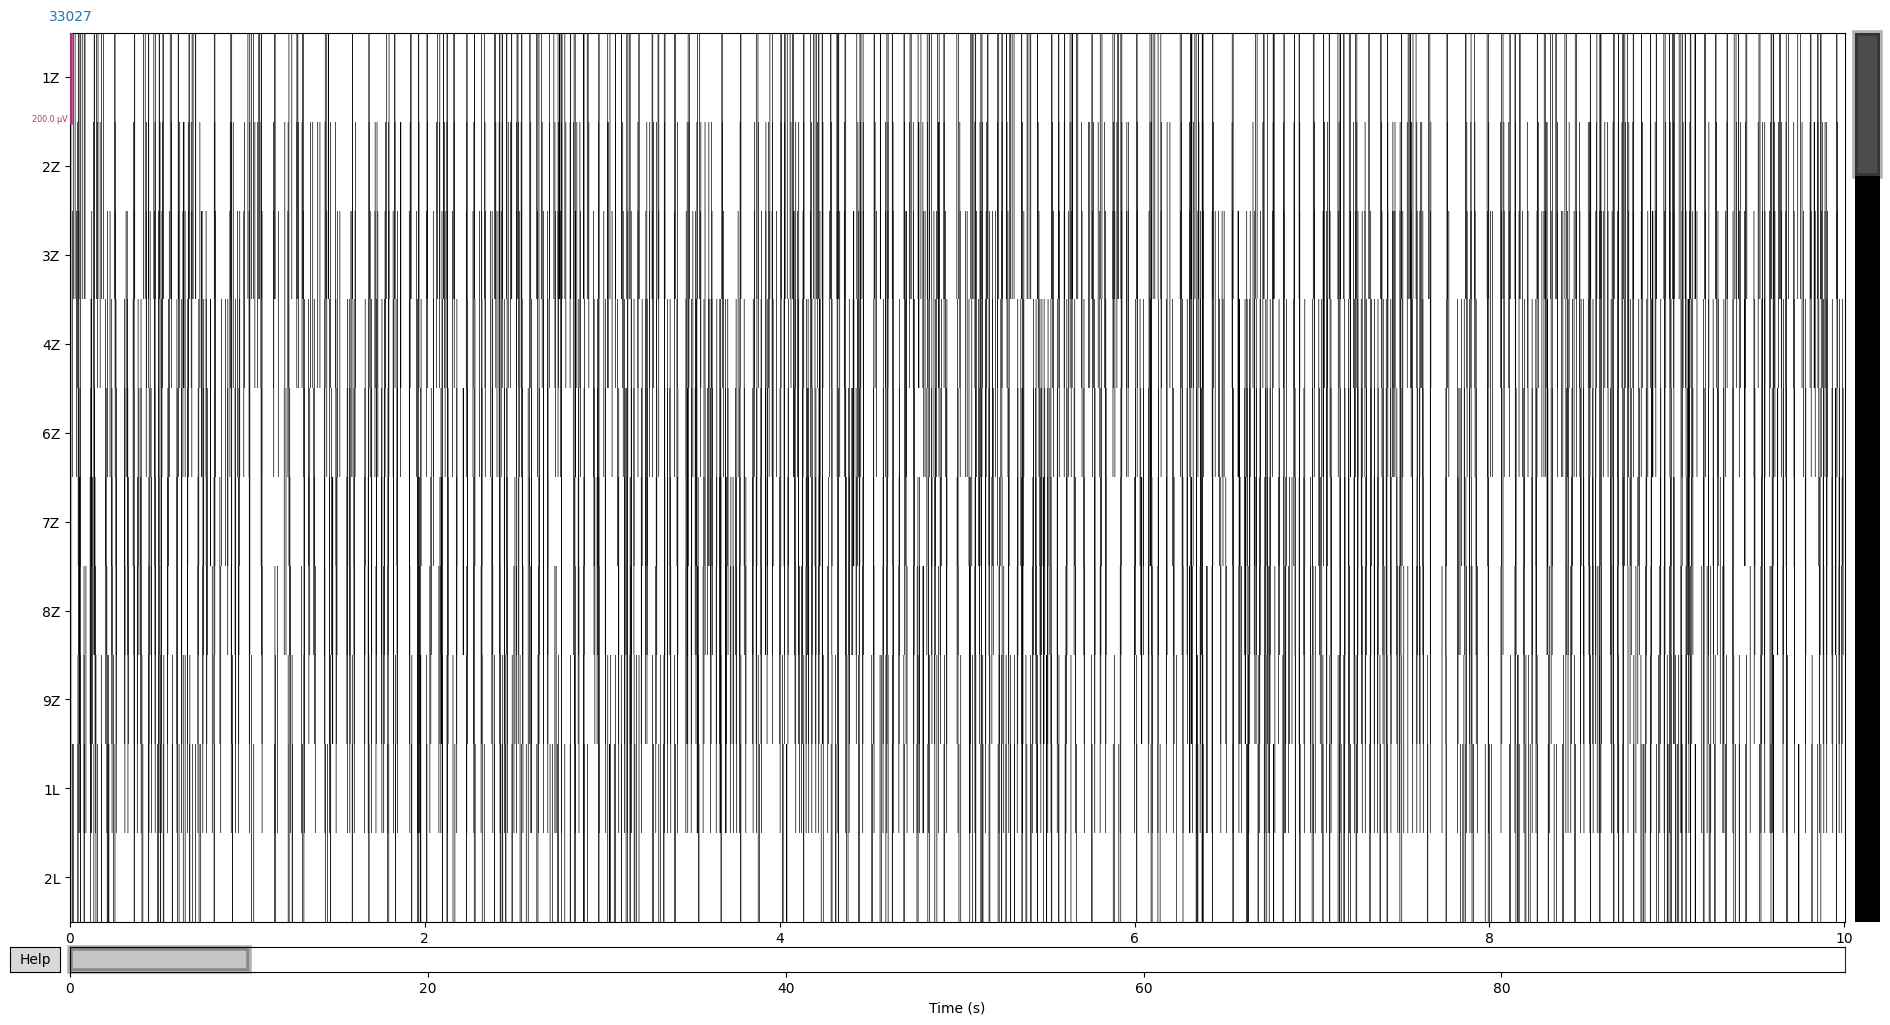

In [11]:
pnum = 8
b_cnt  = 0
block_num =  'ND0'

raw = analysis.processing.loadSegmentedData(pnum, block_num)
raw = raw.apply_function(lambda x: x * 1e6)
raw.filter(l_freq=4., h_freq=30.)
raw.plot(duration= 10, use_opengl= True,  n_channels= 10, scalings = dict(eeg=100e-6))

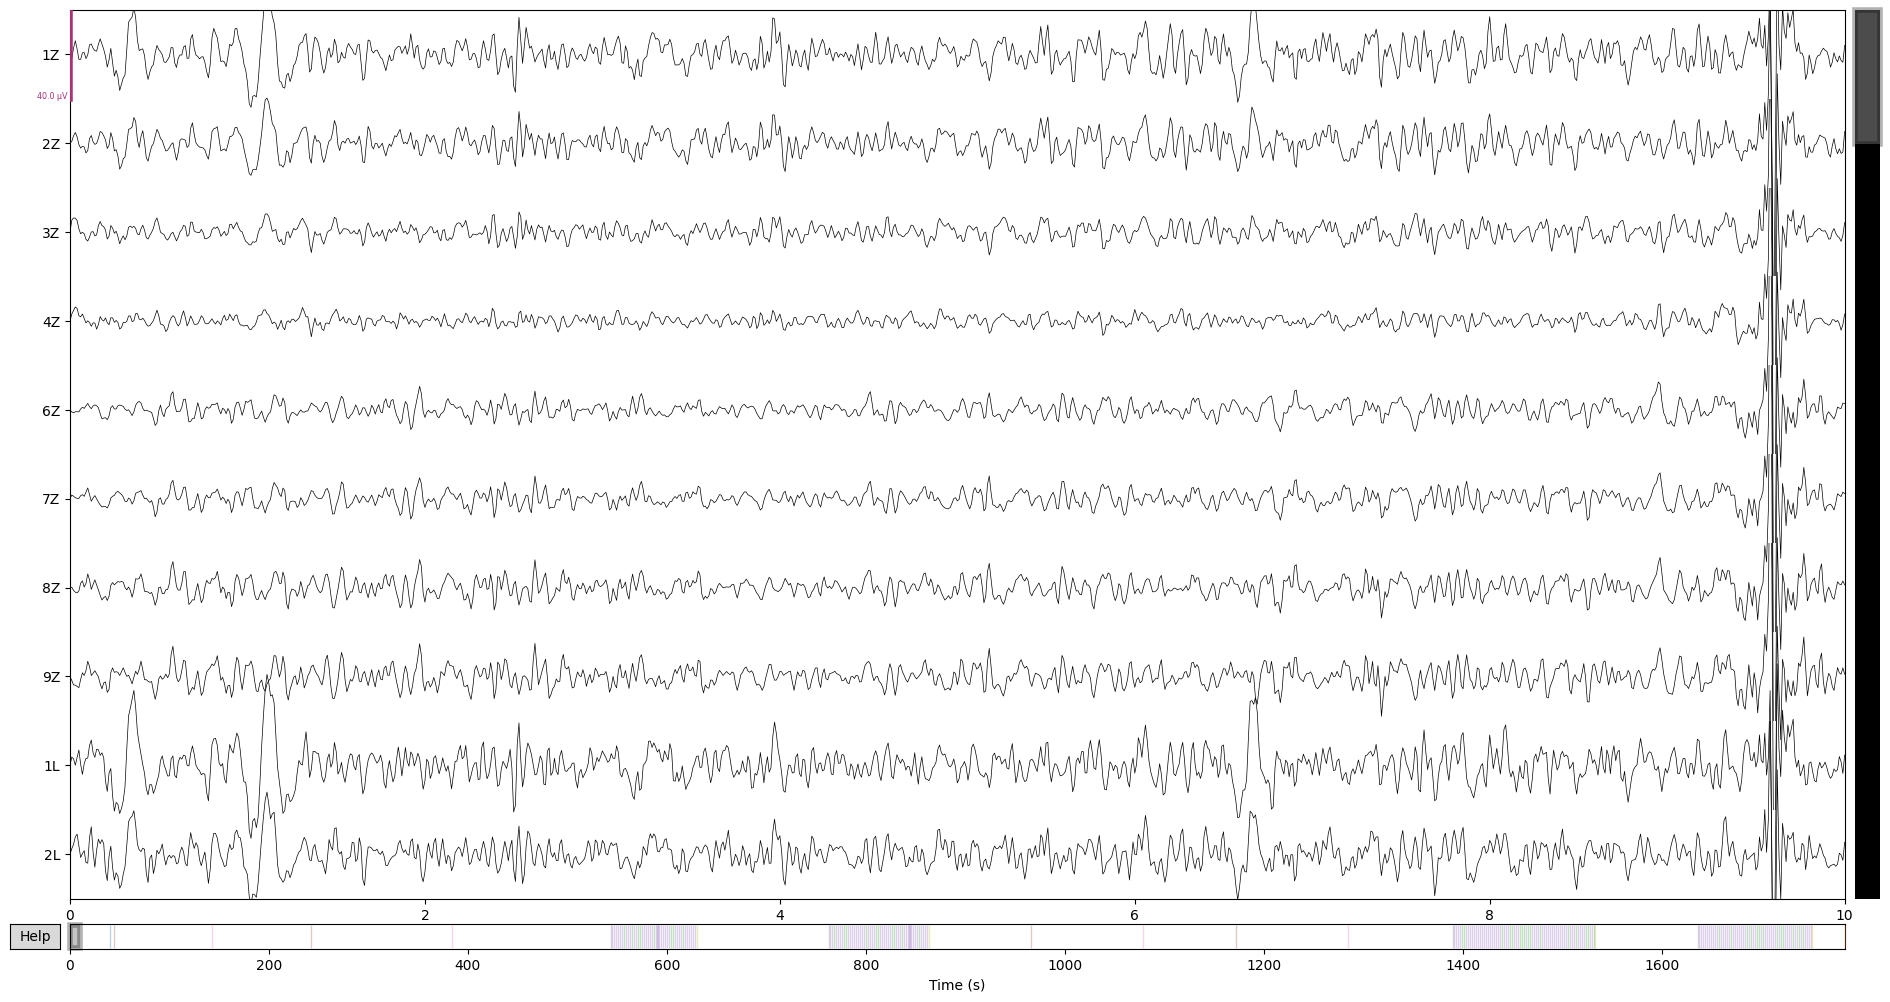

In [10]:
participant_name = 'P' + str(12)
        # partipant_data_path =  'Pilot'+ '/' + participant_name +'.gdf'
partipant_data_path =  participant_name +'.gdf'
path = os.path.join(configss['root'], configss['data_dir'] , partipant_data_path ) 

raw  = mne.io.read_raw_gdf(path, preload = True)
raw.apply_function(lambda x: x * 1e6)
raw.filter(l_freq=4., h_freq=30.)
raw.plot(scalings = dict(eeg=20e-6), use_opengl= True,  n_channels= 10)

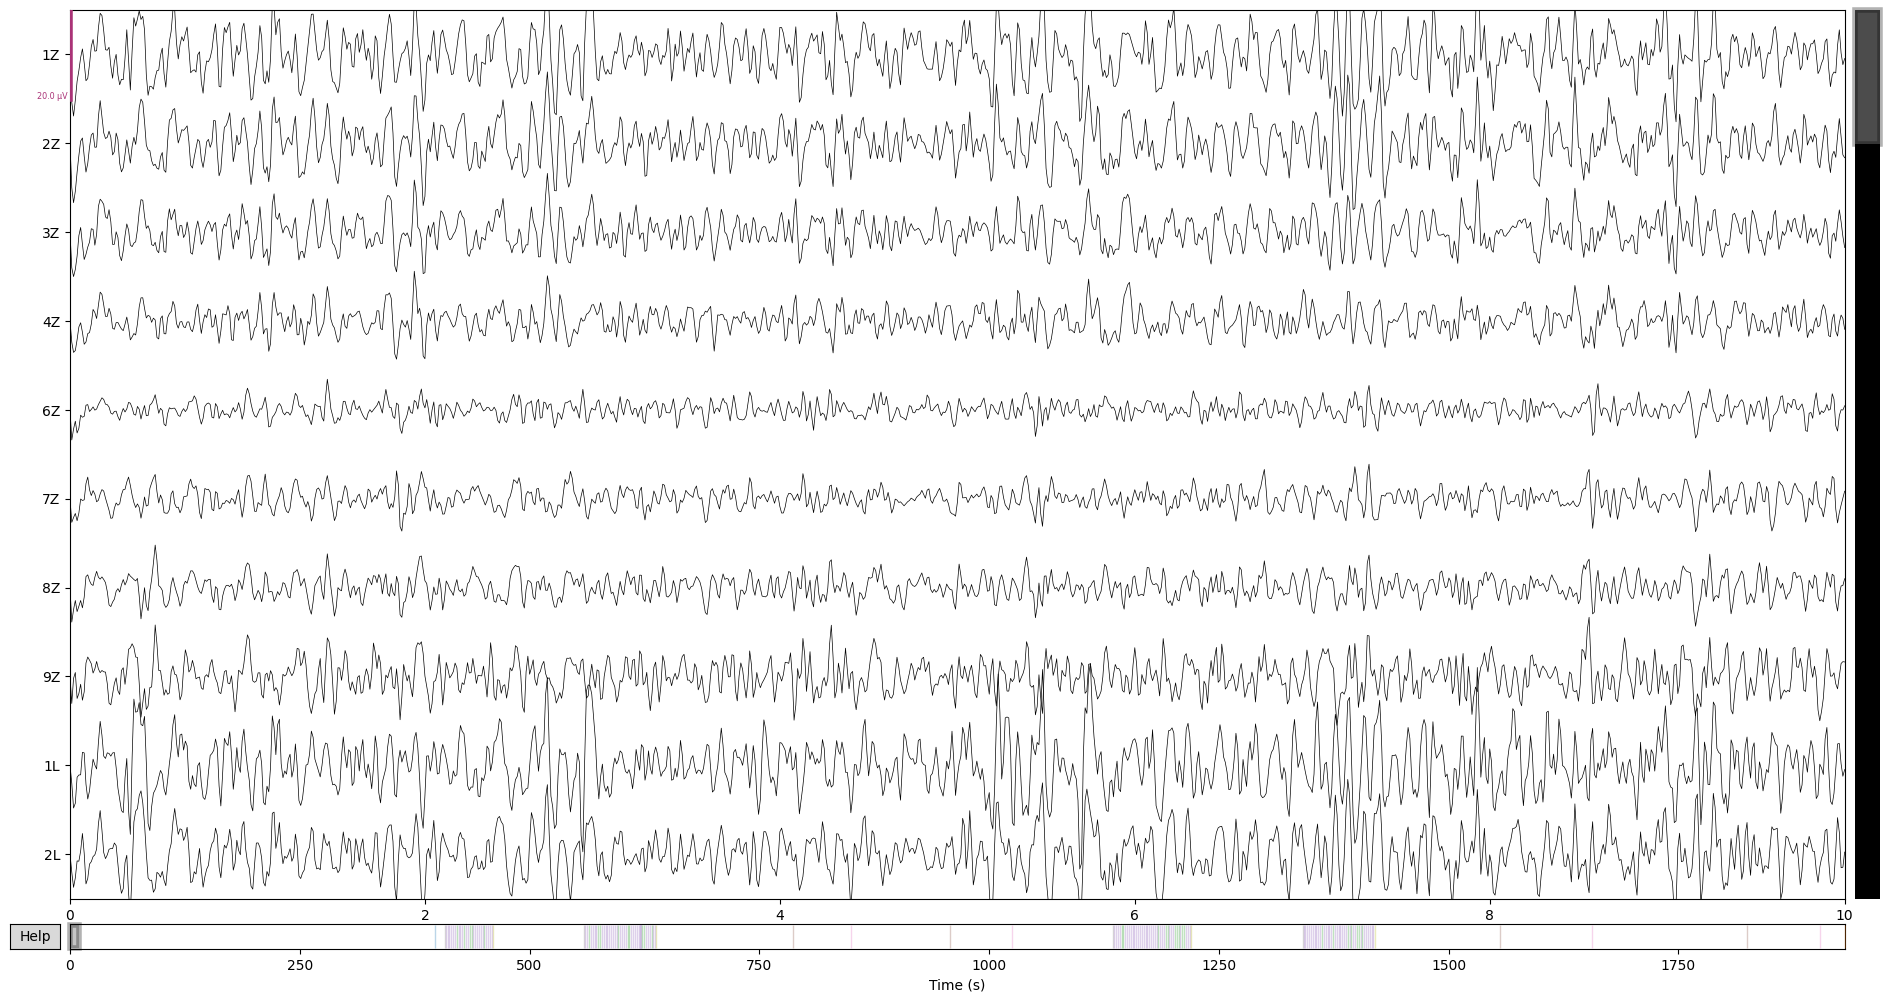

In [14]:
participant_name = 'P' + str(15)
        # partipant_data_path =  'Pilot'+ '/' + participant_name +'.gdf'
partipant_data_path =  participant_name +'.gdf'
path = os.path.join(configss['root'], configss['data_dir'] , partipant_data_path ) 

raw  = mne.io.read_raw_gdf(path, preload = True)
raw.apply_function(lambda x: x * 1e6)
raw.filter(l_freq=4., h_freq=30.)
raw.plot(scalings = dict(eeg=10e-6), use_opengl= True,  n_channels= 10)

In [10]:
raw.ch_names

['1Z',
 '2Z',
 '3Z',
 '4Z',
 '6Z',
 '7Z',
 '8Z',
 '9Z',
 '1L',
 '2L',
 '3L',
 '4L',
 '5L',
 '6L',
 '7L',
 '8L',
 '9L',
 '10L',
 '11L',
 '1R',
 '2R',
 '3R',
 '4R',
 '5R',
 '6R',
 '7R',
 '8R',
 '9R',
 '10R',
 '11R',
 '1LA',
 '2LA',
 '3LA',
 '1LB',
 '2LB',
 '3LB',
 '4LB',
 '5LB',
 '1LC',
 '2LC',
 '3LC',
 '4LC',
 '5LC',
 '1LD',
 '2LD',
 '3LD',
 '4LD',
 '1RA',
 '2RA',
 '3RA',
 '1RB',
 '2RB',
 '3RB',
 '4RB',
 '5RB',
 '1RC',
 '2RC',
 '3RC',
 '4RC',
 '5RC',
 '1RD',
 '2RD',
 '3RD',
 '4RD',
 'Tgt',
 'SC']

In [11]:
con_epochs_array = np.mean(con_epochs_array, axis=4)  # average over timepoints

# In this example, we will just show alpha
foi = list(Freq_Bands.keys()).index("alpha")  # frequency of interest


# Define function for plotting con matrices
def plot_con_matrix(con_data, n_con_methods):
    """Visualize the connectivity matrix."""
    fig, ax = plt.subplots(1, n_con_methods, figsize=(6 * n_con_methods, 6))
    for c in range(n_con_methods):
        # Plot with imshow
        con_plot = ax[c].imshow(con_data[c, :, :, foi], cmap="binary", vmin=0, vmax=1)
        # Set title
        ax[c].set_title(connectivity_methods[c])
        # Add colorbar
        fig.colorbar(con_plot, ax=ax[c], shrink=0.7, label="Connectivity")
        # Fix labels
        ax[c].set_xticks(range(len(ch_names)))
        ax[c].set_xticklabels(ch_names)
        ax[c].set_yticks(range(len(ch_names)))
        ax[c].set_yticklabels(ch_names)
        print(
            f"Connectivity method: {connectivity_methods[c]}\n"
            + f"{con_data[c,:,:,foi]}"
        )
    return fig


plot_con_matrix(con_epochs_array, n_con_methods)

NameError: name 'con_epochs_array' is not defined

In [11]:
pnum = 1
b_cnt  = 0
block_num =  'ND0'

raw = analysis.processing.loadSegmentedData(pnum, block_num)
epochs = mne.make_fixed_length_epochs(raw, duration= 30, preload=False)


corr_matrix = envelope_correlation(epochs).get_data()
print(corr_matrix.shape)


import matplotlib.pyplot as plt
import numpy as np

first_30 = corr_matrix[0]
last_30 = corr_matrix[-1]
corr_matrices = [first_30, last_30]
color_lims = np.percentile(np.array(corr_matrices), [5, 95])
titles = ["First 30 Seconds", "Last 30 Seconds"]

fig, axes = plt.subplots(nrows=1, ncols=2,  constrained_layout=True)
fig.suptitle("Correlation Matrices from First 30 Seconds and Last 30 Seconds")
for ci, corr_matrix in enumerate(corr_matrices):
    ax = axes[ci]
    mpbl = ax.imshow(corr_matrix, clim=color_lims)
    ax.set_xlabel(titles[ci])
cbar = fig.colorbar(ax.images[0], label="Correlation Coefficient")

(3, 62, 62, 1)


In [ ]:
# Permutation stats

# Find the adjacency matrix for EEG channels
adjacency, ch_names = mne.channels.find_ch_adjacency(raw.info, ch_type='eeg')

# Perform cluster permutation test
data = [condition1_data, condition2_data]
try:
    T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
        data,
        n_permutations=10000,
        threshold=dict(start=0, step=0.2),
        tail=0,
        connectivity=adjacency,  # Use the adjacency matrix for neighboring connections
        out_type='mask'
    )
except Exception as e:
    print(f"Error performing cluster permutation test: {e}")
    raise

# Identify significant clusters
significant_clusters = np.where(cluster_p_values < 0.05)[0]
print("Significant clusters: ", significant_clusters)

# Save results to a file (optional)
np.save('significant_clusters.npy', significant_clusters)